# 2. Disminant Learning on eigen-characters - DNN

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../30_Code/")

In [3]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from itertools import islice, filterfalse, chain

In [4]:
import Fusiform

## Data Import

## Character embedding

In [5]:
cwn_vec = Fusiform.CwnNodeVec('homophily')

load CwnNodeVec from cache:  ..\30_Code\Fusiform\..\..\05_Resource\cwn_node_vec_homophily.pkl


In [6]:
cwn_vec.node_most_similar('我')

[('俺', 0.9917283058166504),
 ('咱', 0.9877233505249023),
 ('阮', 0.9762067794799805),
 ('余', 0.9721795320510864),
 ('偶', 0.8739964962005615)]

In [7]:
len(cwn_vec.itos), len(cwn_vec.stoi), cwn_vec.embed.vectors.shape

(18251, 18251, (18251, 100))

In [8]:
cwn_chars = [x for x in cwn_vec.stoi.keys() if len(x)==1]

In [9]:
common_chars = set(cwn_chars)
print(len(common_chars))

3831


## Eigen-character space

In [10]:
cv_path = Fusiform.get_data_path("", "charac_coeff.pkl")
with open(cv_path, "rb") as fin:
    cv_itos, cv_stoi, cv_vectors = pickle.load(fin)
char_space50 = Fusiform.CharacterSpace(cv_itos, cv_stoi, cv_vectors, n_components=50)

In [11]:
from itertools import chain
missed_chars = [x for x in cwn_chars if x not in char_space50.stoi]
n_missed = len(missed_chars)

print(f"OOV: {n_missed}/{len(cwn_chars)} = {n_missed/len(cwn_chars)*100:#.2f}%")
print(missed_chars)

OOV: 165/3831 = 4.31%
['乜', '仞', '佤', '傣', '儆', '兕', '冢', '刖', '剜', '剮', '卍', '呣', '呶', '哂', '唁', '唄', '唎', '啐', '啣', '嗖', '嗝', '嘜', '噉', '噫', '囍', '坳', '坼', '塋', '墬', '壎', '姝', '屙', '岫', '崤', '巳', '巽', '幘', '幛', '弒', '彖', '彘', '徇', '怍', '恒', '戧', '挎', '揜', '搆', '搡', '搴', '搽', '摑', '摜', '撅', '撣', '擤', '攆', '攥', '昵', '柒', '桴', '棱', '椽', '楫', '檮', '櫸', '歿', '殫', '殲', '毐', '沏', '湔', '溱', '瀦', '炖', '炷', '煨', '熗', '燜', '爰', '牖', '犛', '猞', '璊', '甌', '甍', '畈', '疋', '疽', '痹', '瘐', '癘', '皖', '皤', '皴', '眊', '眛', '砵', '砷', '磻', '笞', '筴', '箐', '篠', '篾', '簞', '糸', '綰', '綹', '緡', '纔', '罈', '翕', '耨', '聵', '肱', '胜', '脘', '艮', '苖', '茍', '荑', '荻', '莤', '葸', '蒔', '蒿', '蛆', '蛟', '蜇', '螓', '蠆', '觥', '誚', '豕', '貘', '賒', '贛', '趿', '踅', '踼', '蹻', '轂', '轡', '鈀', '鈸', '鉬', '鉶', '銫', '銻', '錳', '鍆', '鐳', '鑪', '闥', '靛', '鞣', '頜', '鬈', '鬻', '鯢', '鵒', '鶖', '鹵', '麋']


In [12]:
common_chars.intersection_update(char_space50.stoi)
len(common_chars)

3666

## Prepare dataset

In [13]:
def compute_LDL(n_compo):
    char_space = Fusiform.CharacterSpace(cv_itos, cv_stoi, cv_vectors, n_components=n_compo)
    char_list = list(common_chars)
    C = [char_space.vectors[char_space.stoi[x]] for x in char_list]
    C = np.vstack(C)
    S = [cwn_vec.embed.vectors[cwn_vec.stoi[x]] for x in char_list]
    S = np.vstack(S)
    CtC = np.dot(C.transpose(), C)
    CtC_inv = np.linalg.inv(CtC)
    F = np.dot(np.dot(CtC_inv, C.transpose()), S)
    recon_S = np.dot(C, F)
    return C, F, S, recon_S

In [14]:
C, F, S, recon_S = compute_LDL(50)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_C, test_C, train_S, test_S = train_test_split(C, S)

In [17]:
train_C.shape, train_S.shape

((2749, 50), (2749, 100))

## Neural Network

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

In [94]:
class DNN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(n_input, n_hidden), nn.Sigmoid())
        self.fc2 = nn.Sequential(nn.Linear(n_hidden, n_output))
    
    def forward(self, x):
        h = self.fc1(x)
        o = self.fc2(h)
        return o

In [100]:
dnn = DNN(train_C.shape[1], train_S.shape[1], 1000)
sgd = optim.Adagrad(dnn.parameters(), lr=0.005)
loss = nn.MSELoss()
train_losses = []
test_losses = []

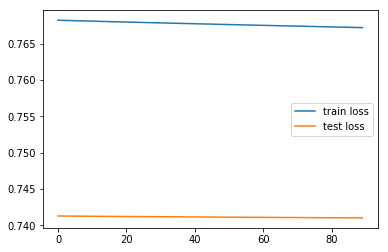

In [101]:
for _ in tqdm(range(100)):
    sgd.zero_grad()
    pred = dnn(torch.FloatTensor(train_C))
    loss_val = loss(pred, torch.FloatTensor(train_S))
    loss_val.backward()
    sgd.step()
    # print(loss_val)    
    train_losses.append(loss_val)
    pred_test = dnn(torch.FloatTensor(test_C))    
    loss_val_test = loss(pred_test, torch.FloatTensor(test_S))
    test_losses.append(loss_val_test)
    
plt.plot(train_losses[10:], label='train loss')
plt.plot(test_losses[10:], label='test loss')
plt.legend()

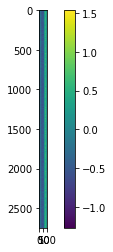

In [97]:
plt.imshow(pred.detach().numpy())
plt.colorbar()

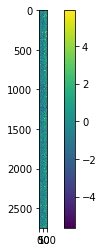

In [98]:
plt.imshow(train_S)
plt.colorbar()

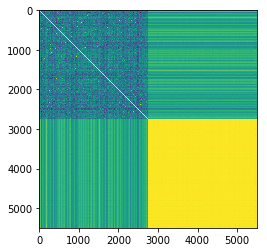

In [99]:
plt.imshow(np.corrcoef(train_S, pred.detach().numpy()))